In [1]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/etc/jupyter"
#path = "~/.jupyter"
cm = BaseJSONConfigManager(config_dir=path)
#cm.update('livereveal', {
#              'theme': 'beige',
#              'transition': 'convex',
#              'start_slideshow_at': 'selected',
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})
cm.update('livereveal', {
              'width': 1024,
              'height': 768,
})
cm.update('livereveal', {
              'scroll': True,
})

{u'height': 768,
 'scroll': True,
 u'start_slideshow_at': u'selected',
 u'theme': u'sky',
 u'transition': u'zoom',
 u'width': 1024}

# First Modtran LibRadTran Models comparison
===============================

- author Sylvie Dagoret-Campagne
- date January 5th 2017

We have the very first Modtran file. But I don't really know what is its airmass, PWV and Ozone.
Thus I will plot a set of LibTradTran curves to find the good one.


In [2]:
import rise
rise.__version__

'4.0.0b1'

In [3]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline


/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
import pandas as pd
import os
import re
import numpy as np

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [6]:
from scipy.interpolate import interp1d

In [7]:
import libLSSTMagnitude as magnit

### Path to Modtran File

In [8]:
modtran_atmfile="mt.txt"

### Get the Header from file

In [9]:
df_header=pd.read_csv(modtran_atmfile, sep="\t",header=None,usecols=range(0,4))
df_header=df_header[:5]
df_header

,0,1,2,3
0,361976 U,S STAND,ARD,NaN
1,2.70000 1,0,0 33.6,0000 11
2,NaN,NaN,NaN,NaN
3,WL,H2O,O3,MOLEC
4,(NM),TRANS,TRANS,SCAT


### Get the Data from file

In [10]:
df = pd.read_csv(modtran_atmfile, sep="\t", header=4,usecols=range(0,4))
df.columns = ["wl", "h2o", "o3","scat"]
df.head()

,wl,h2o,o3,scat
0,250.0,1.0,0.0,0.0960
1,250.5,1.0,0.0,0.0981
2,251.0,1.0,0.0,0.1001
3,251.5,1.0,0.0,0.1022
4,252.0,1.0,0.0,0.1043


### Extract Modtran Data

In [11]:
MT_X=df["wl"]
MT_Y1=df["h2o"]
MT_Y2=df["o3"]
MT_Y3=df["scat"]
MT_Y=MT_Y1*MT_Y2*MT_Y3

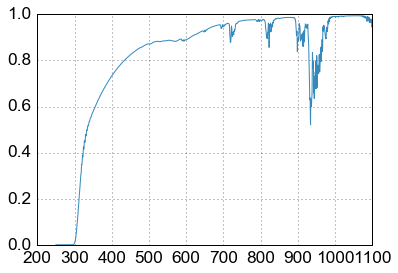

In [12]:
plt.figure(figsize=(6,4))
plt.plot(MT_X,MT_Y)

### Path to LibRadTran files for pure scattering atmosphere

In [13]:
path_atm_rt_us_sc="/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/PC5AtmosphericExtinction/LibRadTran/simulations/RT/2.0/LS/pp/us/sc/out"

### Path to LibRadTran for pure absorbing atmosphere

- pwv : warying water vapor
- oz  : varying ozone 

In [14]:
path_atm_rt_us_ab_rt_oz='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/PC5AtmosphericExtinction/LibRadTran/simulations/RT/2.0/LS/pp/us/ab/rt/oz/out'
path_atm_rt_us_ab_rt_pwv='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/PC5AtmosphericExtinction/LibRadTran/simulations/RT/2.0/LS/pp/us/ab/rt/wv/out'

### Path to LibRadTran for scattering and absorbing atmosphere

- pwv : warying water vapor
- oz  : varying ozone 

In [15]:
path_atm_rt_us_sa_rt_oz='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/PC5AtmosphericExtinction/LibRadTran/simulations/RT/2.0/LS/pp/us/sa/rt/oz/out'
path_atm_rt_us_sa_rt_pwv='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/PC5AtmosphericExtinction/LibRadTran/simulations/RT/2.0/LS/pp/us/sa/rt/pwv/out'

## A) Pure Scattering
===========================

In [16]:
# get the list of files
input_filelist=os.listdir(path_atm_rt_us_sc) 

In [17]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [18]:
input_filelist[:5]

array(['RT_LS_pp_us_sc_rt_z10.OUT', 'RT_LS_pp_us_sc_rt_z11.OUT',
       'RT_LS_pp_us_sc_rt_z12.OUT', 'RT_LS_pp_us_sc_rt_z13.OUT',
       'RT_LS_pp_us_sc_rt_z14.OUT'], 
      dtype='|S25')

In [19]:
NB_RTFILES=input_filelist.shape[0] # Number of files
fullfile=fullfilename=os.path.join(path_atm_rt_us_sc,input_filelist[0])
data=np.loadtxt(fullfile)
NB_WL=data.shape[0]  # number of wavelength

In [20]:
rt_airmasses=np.zeros(NB_RTFILES)
rt_data_list = []
rt_trans = np.zeros([NB_WL,NB_RTFILES])
rt_wl=np.zeros([NB_WL,NB_RTFILES])

for idx,file in np.ndenumerate(input_filelist):
    str_airmass=re.findall('^RT_LS_pp_us_sc_rt_z(.*).OUT',file)[0] # decode airmass from filename
    fullfilename=os.path.join(path_atm_rt_us_sc,file)
    data=np.loadtxt(fullfilename) # read data from file
    rt_data_list.append(data)   # save data
    rt_wl[:,idx[0]]=data[:,0]
    rt_trans[:,idx[0]]=data[:,1]
    rt_airmasses[idx[0]]=float(str_airmass)/10.

### Airmasses
----------------

In [21]:
rt_airmasses

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ])

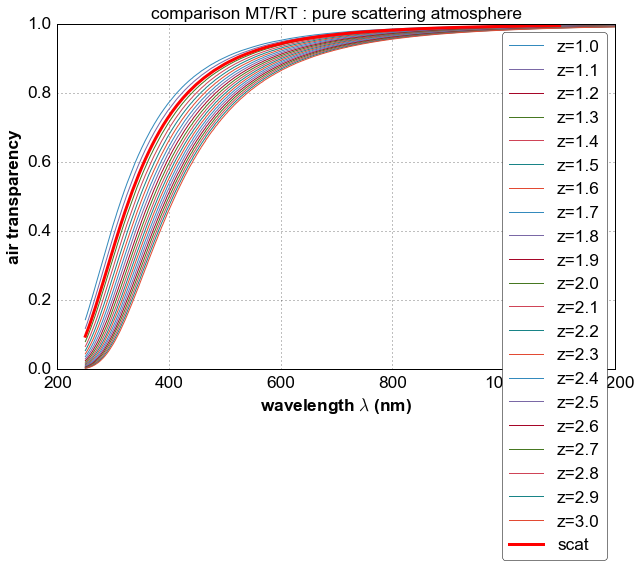

In [22]:
for idx,file in np.ndenumerate(input_filelist):
    index=idx[0]
    airmass=rt_airmasses[index]
    thelegend="z={:3.1f}".format(airmass)
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    plt.plot(x,y,label=thelegend)
plt.plot(MT_X,MT_Y3,'r-',lw=3)
plt.title("comparison MT/RT : pure scattering atmosphere")
plt.xlabel("wavelength $\lambda$ (nm)")
plt.ylabel("air transparency")
plt.legend()


Here above, we have plotted as fine lines, the air transparency for scattering only in LibRadTan.
The Thich line is ModTran.
We see the equivalent airmass depth is for $z=1.2$ for LibRadTran

### Get the same X-points for LibRadTran and Modtran by interpolation

In [23]:
# range of wavelength in Modtran
WLMIN=MT_X.min()
WLMAX=MT_X.max()

In [24]:
interpol_atm_mt=interp1d(MT_X,MT_Y3)

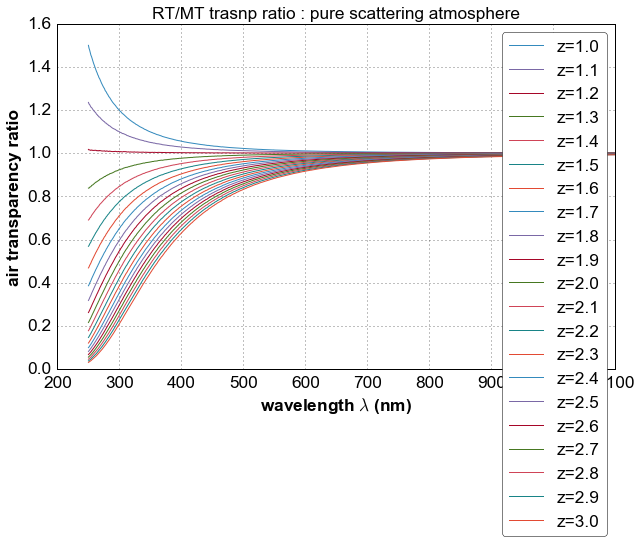

In [25]:
for idx,file in np.ndenumerate(input_filelist):
    index=idx[0]
    airmass=rt_airmasses[index]
    thelegend="z={:3.1f}".format(airmass)
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    indexes=np.where(np.logical_and(x>=WLMIN,x<=WLMAX))
    newx=x[indexes]
    newy=y[indexes]
    newymt=interpol_atm_mt(newx)
    ratio=newy/newymt
    plt.plot(newx,ratio,label=thelegend)
    plt.title("RT/MT trasnp ratio : pure scattering atmosphere")
    plt.xlabel("wavelength $\lambda$ (nm)")
    plt.ylabel("air transparency ratio")
    plt.legend(loc=1)

Here above, we have plotted as fine lines, the air transparency ratio Modtran/LibRadTran for scattering only in LibRadTan.
The legend indicate the airmass in LibRadTran
We see the equivalent airmass depth is for $z=1.2$ for LibRadTran

## For MT/RT Comparison, need to select airmass z=1.2 in libradtran to have same atmospheric depth

## B) Pure Absorbing atmosphere for Water Vapor
==============================================================

In [26]:
# get the list of files
input_filelist=os.listdir(path_atm_rt_us_ab_rt_pwv) 

In [27]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [28]:
input_filelist[:5]

array(['RT_LS_pp_us_ab_rt_z10_wv0.OUT', 'RT_LS_pp_us_ab_rt_z10_wv10.OUT',
       'RT_LS_pp_us_ab_rt_z10_wv100.OUT',
       'RT_LS_pp_us_ab_rt_z10_wv105.OUT', 'RT_LS_pp_us_ab_rt_z10_wv110.OUT'], 
      dtype='|S31')

### Select the good airmass according the filename

In [29]:
input_filelist2 = []

In [30]:
for file in input_filelist:
    if re.search("^RT_LS_pp_us_ab_rt_z12_",file): # regular expression from filename
        input_filelist2.append(file)
input_filelist2=np.array(input_filelist2)

In [31]:
input_filelist2[:5]

array(['RT_LS_pp_us_ab_rt_z12_wv0.OUT', 'RT_LS_pp_us_ab_rt_z12_wv10.OUT',
       'RT_LS_pp_us_ab_rt_z12_wv100.OUT',
       'RT_LS_pp_us_ab_rt_z12_wv105.OUT', 'RT_LS_pp_us_ab_rt_z12_wv110.OUT'], 
      dtype='|S31')

In [32]:
NB_RTFILES=input_filelist2.shape[0] # Number of files
fullfile=fullfilename=os.path.join(path_atm_rt_us_ab_rt_pwv,input_filelist2[0])
data=np.loadtxt(fullfile)
NB_WL=data.shape[0]  # number of wavelength

In [33]:
rt_trans = np.zeros([NB_WL,NB_RTFILES])
rt_wl=np.zeros([NB_WL,NB_RTFILES])
rt_pwv=np.zeros(NB_RTFILES)

for idx,file in np.ndenumerate(input_filelist2):
    str_pwv=re.findall('^RT_LS_pp_us_ab_rt_z12_wv(.*).OUT',file)[0] # decode pwv from filename
    fullfilename=os.path.join(path_atm_rt_us_ab_rt_pwv,file)
    data=np.loadtxt(fullfilename) # read data from file
    rt_data_list.append(data)   # save data
    rt_wl[:,idx[0]]=data[:,0]
    rt_trans[:,idx[0]]=data[:,1]
    rt_pwv[idx[0]]=float(str_pwv)/10.
    

### Precipitable water vapor in LibRadTran

In [34]:
rt_pwv

array([  0. ,   1. ,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,   1.5,  15. ,   2. ,   2.5,   3. ,   3.5,
         4. ,   4.5,   0.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,
         8. ,   8.5,   9. ,   9.5])

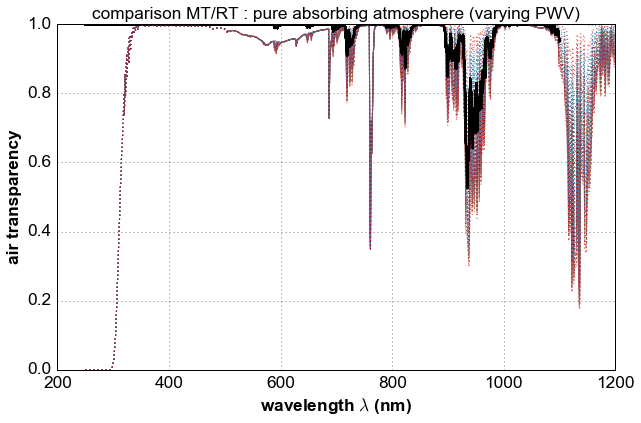

In [35]:
for idx,file in np.ndenumerate(input_filelist2):
    index=idx[0]
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    plt.plot(x,y,':')
    plt.plot(MT_X,MT_Y1,'k-',lw=2)
    plt.title("comparison MT/RT : pure absorbing atmosphere (varying PWV)")
    plt.xlabel("wavelength $\lambda$ (nm)")
    plt.ylabel("air transparency")

- Black-line is Modtran
- OK we expect no ozone here. That's correct

### Get the same X-points for LibRadTran and Modtran by interpolation

In [36]:
WLMIN=700 # avoid ozone region because there is no ozone in Modtran

In [37]:
interpol_atm_mt=interp1d(MT_X,MT_Y1)

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


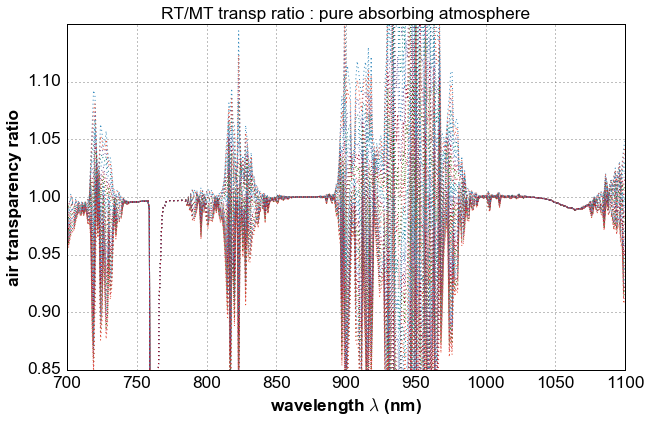

In [38]:
for idx,file in np.ndenumerate(input_filelist2):
    index=idx[0]
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    indexes=np.where(np.logical_and(x>=WLMIN,x<=WLMAX))
    newx=x[indexes]
    newy=y[indexes]
    newymt=interpol_atm_mt(newx)
    ratio=newy/newymt
    plt.plot(newx,ratio,":")
    plt.title("RT/MT transp ratio : pure absorbing atmosphere")
    plt.xlabel("wavelength $\lambda$ (nm)")
    plt.ylabel("air transparency ratio")
    plt.ylim(0.85,1.15)
    plt.legend(loc=1)

### Of course, O2 absorption is missing, by the way, could I have it also ?

- there is an additional absorption in LibRadTran at 1075 nm
- Derive the PWV in Modtran below:

### Find PWV in Modtran

In [39]:
# defines WL range where to compute the distance MT-RT
WLMINCut=800
WLMAXCut=1000

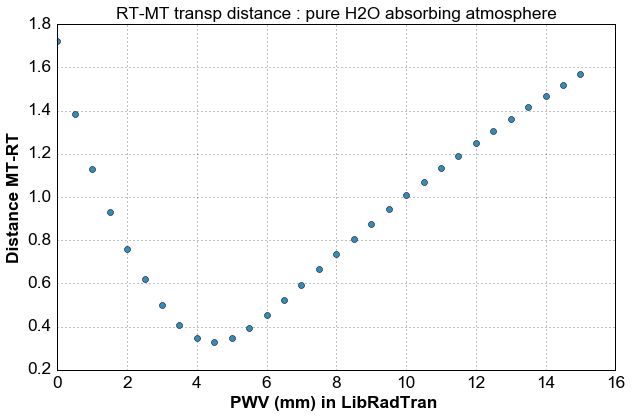

In [40]:
XX=[]
YY=[]
for idx,file in np.ndenumerate(input_filelist2):
    index=idx[0]
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    indexes=np.where(np.logical_and(x>=WLMINCut,x<=WLMAXCut))
    newx=x[indexes]
    newy=y[indexes]
    newymt=interpol_atm_mt(newx)
    diff2=(newy-newymt)**2
    thesum=np.sum(diff2)
    XX.append(rt_pwv[index])
    YY.append(np.sqrt(thesum))
    
plt.plot(XX,YY,"o")
plt.title("RT-MT transp distance : pure H2O absorbing atmosphere")
plt.xlabel("PWV (mm) in LibRadTran ")
plt.ylabel("Distance MT-RT")

** So Modtran simulation is compativle with $PXW=4.5$mm ! **

## C) Pure Absorbing atmosphere for Ozone
==============================================================

In [41]:
# get the list of files
input_filelist=os.listdir(path_atm_rt_us_ab_rt_oz) 

In [42]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [43]:
input_filelist[:5]

array(['RT_LS_pp_us_ab_rt_z10_oz20.OUT', 'RT_LS_pp_us_ab_rt_z10_oz22.OUT',
       'RT_LS_pp_us_ab_rt_z10_oz24.OUT', 'RT_LS_pp_us_ab_rt_z10_oz26.OUT',
       'RT_LS_pp_us_ab_rt_z10_oz28.OUT'], 
      dtype='|S30')

### Select airmasses corresponding to that of Modtran

- select z=1.2

In [44]:
input_filelist3=[]

In [45]:
for file in input_filelist:
    if re.search("^RT_LS_pp_us_ab_rt_z12_",file): # regular expression from filename
        input_filelist3.append(file)
input_filelist3=np.array(input_filelist3)

In [46]:
NB_RTFILES=input_filelist3.shape[0] # Number of files
fullfile=fullfilename=os.path.join(path_atm_rt_us_ab_rt_oz,input_filelist3[0])
data=np.loadtxt(fullfile)
NB_WL=data.shape[0]  # number of wavelength

In [47]:
rt_trans = np.zeros([NB_WL,NB_RTFILES])
rt_wl=np.zeros([NB_WL,NB_RTFILES])
rt_oz=np.zeros(NB_RTFILES)
for idx,file in np.ndenumerate(input_filelist3):
    str_oz=re.findall('^RT_LS_pp_us_ab_rt_z12_oz(.*).OUT',file)[0] # decode pwv from filename
    fullfilename=os.path.join(path_atm_rt_us_ab_rt_oz,file)
    data=np.loadtxt(fullfilename) # read data from file
    rt_data_list.append(data)   # save data
    rt_wl[:,idx[0]]=data[:,0]
    rt_trans[:,idx[0]]=data[:,1]
    rt_oz[idx[0]]=float(str_oz)*10

In [48]:
rt_oz

array([ 200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,  360.,
        380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,  540.,
        560.,  580.,  600.])

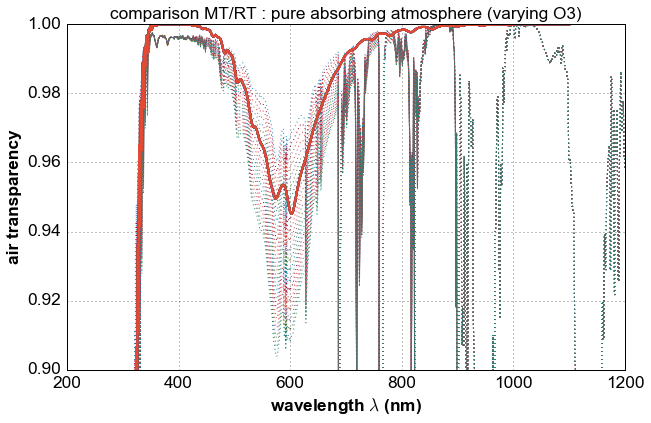

In [49]:
for idx,file in np.ndenumerate(input_filelist3):
    index=idx[0]
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    plt.plot(x,y,':')
    plt.plot(MT_X,MT_Y2,'-',lw=2)
    plt.title("comparison MT/RT : pure absorbing atmosphere (varying O3)")
    plt.xlabel("wavelength $\lambda$ (nm)")
    plt.ylabel("air transparency")
    plt.ylim(0.9,1)

Very interesting, there is a disagrement MT/RT at the 400 nm plateau:
- ** disagreement is less than 0.5 % ** (looks like a libradtran bug)
- in LibRadtran, there seems to be still Ozone effect at short wavelength
- ratio calculation done below:


###  Going to compute the ratio

In [50]:
WLMIN=MT_X.min()
WLMAX=MT_X.max()

WLMAX=800 # avoid PWV region 

In [51]:
interpol_atm_mt=interp1d(MT_X,MT_Y2)

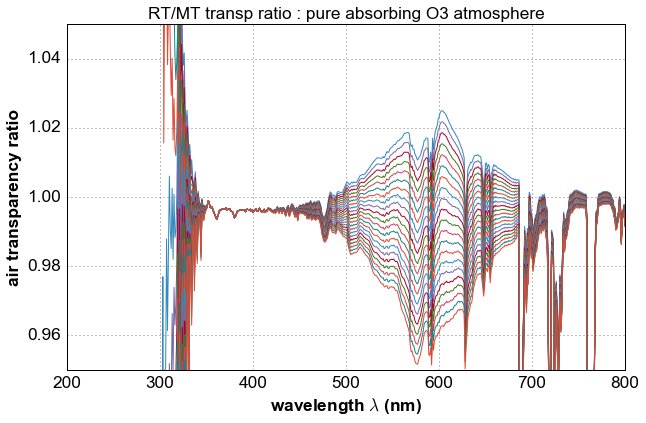

In [52]:
for idx,file in np.ndenumerate(input_filelist3):
    index=idx[0]
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    indexes=np.where(np.logical_and(x>=WLMIN,x<=WLMAX))
    newx=x[indexes]
    newy=y[indexes]
    newymt=interpol_atm_mt(newx)
    ratio=newy/newymt
    plt.plot(newx,ratio,"-")
    plt.title("RT/MT transp ratio : pure absorbing O3 atmosphere")
    plt.xlabel("wavelength $\lambda$ (nm)")
    plt.ylabel("air transparency ratio")
    plt.ylim(0.95,1.05)
    plt.legend(loc=1)

In [53]:
WLMINCut=500
WLMAXCut=675

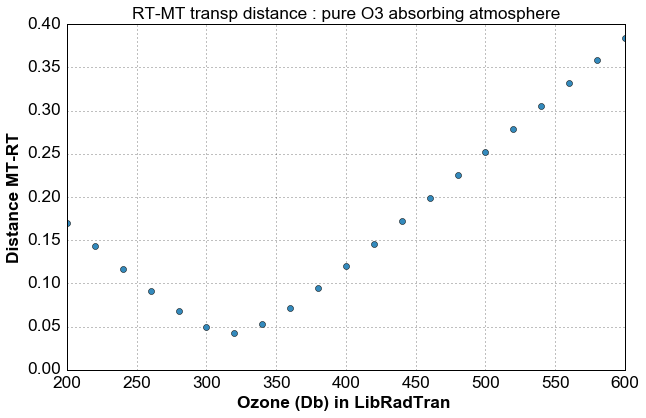

In [54]:
XX=[]
YY=[]
for idx,file in np.ndenumerate(input_filelist3):
    index=idx[0]
    x=rt_wl[:,index]
    y=rt_trans[:,index]
    indexes=np.where(np.logical_and(x>=WLMINCut,x<=WLMAXCut))
    newx=x[indexes]
    newy=y[indexes]
    newymt=interpol_atm_mt(newx)
    diff2=(newy-newymt)**2
    thesum=np.sum(diff2)
    XX.append(rt_oz[index])
    YY.append(np.sqrt(thesum))
    
plt.plot(XX,YY,"o")
plt.title("RT-MT transp distance : pure O3 absorbing atmosphere")
plt.xlabel("Ozone (Db) in LibRadTran ")
plt.ylabel("Distance MT-RT")

** So Modtran ozone is compatible with $OZ= 320$ Db **

## Conclusion
==================

- Stranges but not huges discrepancies Modtran/LibRadTran
- Need also O2 Absorption in ModTran